# Process Tail Sitter Frequency Response
This program is used to process tail sitter data to frequency response while cruising



In [16]:
#coding=utf-8 
%load_ext autoreload
%matplotlib inline
import sys
sys.path.insert(0, '../')
from AircraftIden.data_case.GeneralAircraftCase import GeneralAircraftCase, PX4AircraftCase
from AircraftIden import *
from AircraftIden.TransferFunctionFit import plot_fitter
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rc('figure', figsize=(20.0, 10.0))

def show_logs(px4_case: PX4AircraftCase):
    print("LOW")
    needed_data = ['ele', 'q', 'thr', 'body_vx', "iden_start_time"]
    t_arr, data_list = px4_case.get_data_time_range_list(needed_data)
    print(t_arr)
    data_list[-1] = data_list[-1]/10
    plt.figure("Ele")
    plt.grid(which='both')
    plt.plot(t_arr, data_list[0], 'r.', label='ele')

    plt.figure("sourcedata")
    # print(t_arr)
    # print(data_list)
    for i in range(needed_data.__len__()):
        plt.plot(t_arr, data_list[i], label=needed_data[i])
    plt.legend()
    plt.show()


def split_logs(px4_case:PX4AircraftCase):
    needed_data = ["iden_start_time"]
    print("Will start split data with", needed_data)
    t_arr, data_list = px4_case.get_data_time_range_list(needed_data)
    iden_start_time = data_list[-1]
    data_splited = []
    is_in_a_test = False
    for i in range(1, t_arr.__len__()-1):
        if (iden_start_time[i] > iden_start_time[i+1] or (len(data_splited) > 0 and t_arr[i] - data_splited[-1]["start"] > 20)) \
                and is_in_a_test:
            data_splited[-1]["end"] = t_arr[i]
#             print("Data split {}th, {:5.2f}:{:5.2f}  len {:5.2f}".format(
#                 data_splited.__len__(), data_splited[-1]["start"], data_splited[-1]["end"],
#                 data_splited[-1]["end"] - data_splited[-1]["start"]
#             ))
            is_in_a_test = False

        # if (0 <= iden_start_time[i] < iden_start_time[i-1] and iden_start_time[i] < iden_start_time[i+1]):
        if (iden_start_time[i-1] <=0 and 0 < iden_start_time[i]):
            # Is a start
            is_in_a_test = True
            data_splited.append({"start": t_arr[i]})

    return data_splited


def join_data(data_splited, status):
    joined_data_status = {}
    assert data_splited.__len__() == status.__len__(), "Status Length must equal to data_split but {} {}".format(
        data_splited.__len__(), status.__len__())

    for i in range(data_splited.__len__()):
        status_test = status[i]
        if status_test == "-" or status_test == "wrong":
            continue
        if status_test in joined_data_status:
            #Join data
            joined_data_status[status_test].append((data_splited[i]["start"],data_splited[i]["end"]))
        else:
            joined_data_status[status_test] = [(data_splited[i]["start"], data_splited[i]["end"])]
    return joined_data_status

def split_and_join_data(px4_case:PX4AircraftCase,status):
    sp = split_logs(px4_case)
    return join_data(sp,status)


def plot_status_data(test_case, joined_data_status,needed_data):
    for key in joined_data_status:
        plt.figure("Data case: {}".format(key))
        plt.title("Data case: {}".format(key))
        total_time, t_data, datas = test_case.get_concat_data(joined_data_status[key], needed_data,False)
        for i in range(0, needed_data.__len__()):
            data = datas[needed_data[i]]
#             if needed_data[i] == "pitch":
#                 data = datas[needed_data[i]] * 180/3.1415

            trim_value = np.average(data)
            plt.plot(t_data, data, label=needed_data[i]+" Trim: {:4.2f}".format(trim_value))
            pass
        plt.legend()
        plt.grid(which='both')
    plt.show()

def process_status_data(test_case, joined_data_status,omg_min,omg_max,win_num=None):
    needed_data = ['ele', 'q']
    res = {}
    for key in joined_data_status:
        total_time, t_data, datas = test_case.get_concat_data(joined_data_status[key], needed_data)
        iden = FreqIdenSIMO(t_data, omg_min, omg_max, datas['ele'], datas['q'], uniform_input=True, win_num=None)#,assit_input=datas["thr"])
        res[key] = iden
    return res


def plot_idens_for_status(idens):
    for key in idens:
        iden = idens[key]
        plt.figure("ele_q")
        iden.plt_bode_plot(0, label=key)
        
      
    plt.show()



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
fpath = "/Users/plane/Dropbox/FLYLOG/foam-tail-sitter/cruising/log_34_2018-4-10-16-16-04.ulg"
status = [
        "5m/s", "5m/s", "5m/s", "5m/s", "5m/s", "5m/s", "5m/s", "5m/s",
        "8m/s", "8m/s", "8m/s", "8m/s", "8m/s", "8m/s","8m/s", "8m/s",
        "10m/s", "10m/s", "10m/s", "10m/s", "10m/s", "10m/s","10m/s", "10m/s",
]

status_low = [
        "1m/s", "1m/s", "1m/s", "1m/s", "1m/s", "1m/s", "1m/s", "1m/s",
        "3m/s", "3m/s", "3m/s", "3m/s", "3m/s", "3m/s","3m/s", "3m/s",
        "-", "-", "-"
]

Opening log file /Users/plane/Dropbox/FLYLOG/foam-tail-sitter/cruising/log_34_2018-4-10-16-16-04.ulg
Parse sensor gyro
Parse vehicle attitude sp
sample rate 8.408163427304714


C:\Users\plane\Anaconda3\lib\site-packages\scipy\interpolate\interpolate.py:610: RuntimeWarning: invalid value encountered in true_divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]


Parse vehicle attitude
vehicle_iden_status
sensor_accel
sensor_accel
vehicle_local_position
Try to transform vx vy vz into body frame


C:\Users\plane\Anaconda3\lib\site-packages\pymavlink\quaternion.py:264: RuntimeWarning: invalid value encountered in true_divide
  return q / n


actuator_controls_0
LOW
[0.00000000e+00 5.00005048e-03 1.00001010e-02 ... 5.90060957e+02
 5.90065957e+02 5.90070957e+02]


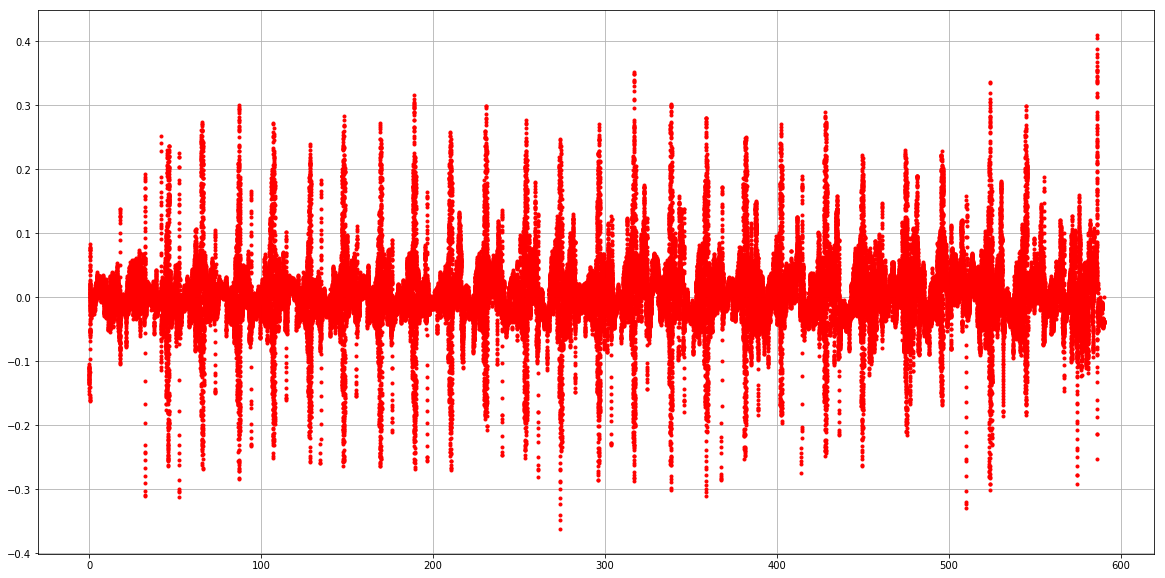

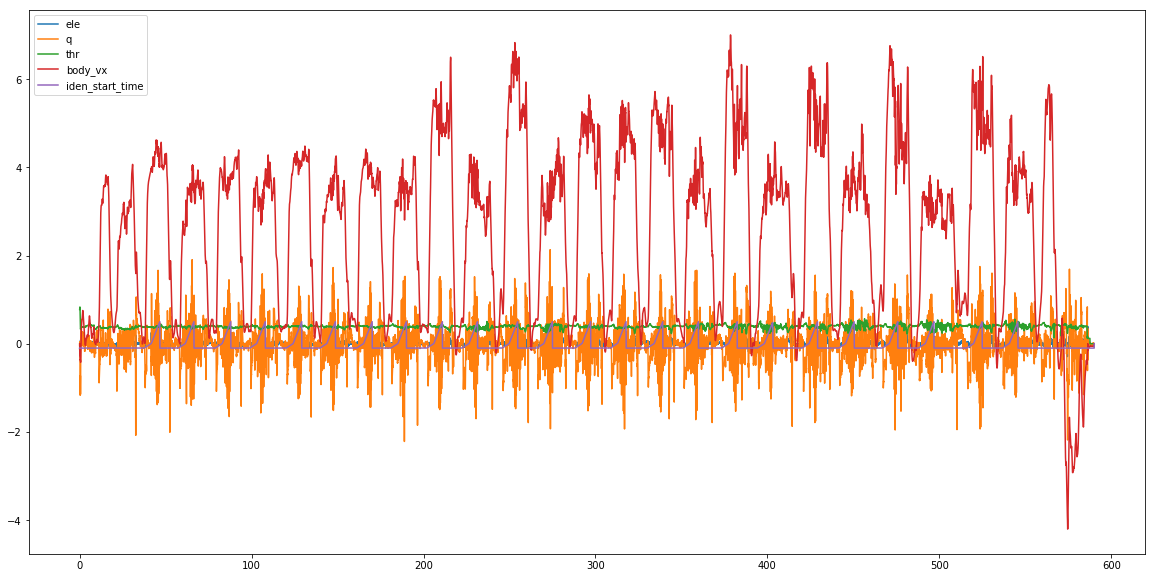

Opening log file /Users/plane/Dropbox/FLYLOG/foam-tail-sitter/cruising/log_32_2018-4-10-15-53-08.ulg
Parse sensor gyro
Parse vehicle attitude sp
sample rate 8.561547340518896
Parse vehicle attitude
vehicle_iden_status
sensor_accel
sensor_accel
vehicle_local_position
Try to transform vx vy vz into body frame
actuator_controls_0
LOW
[0.00000000e+00 5.00008753e-03 1.00001751e-02 ... 5.61814835e+02
 5.61819835e+02 5.61824835e+02]


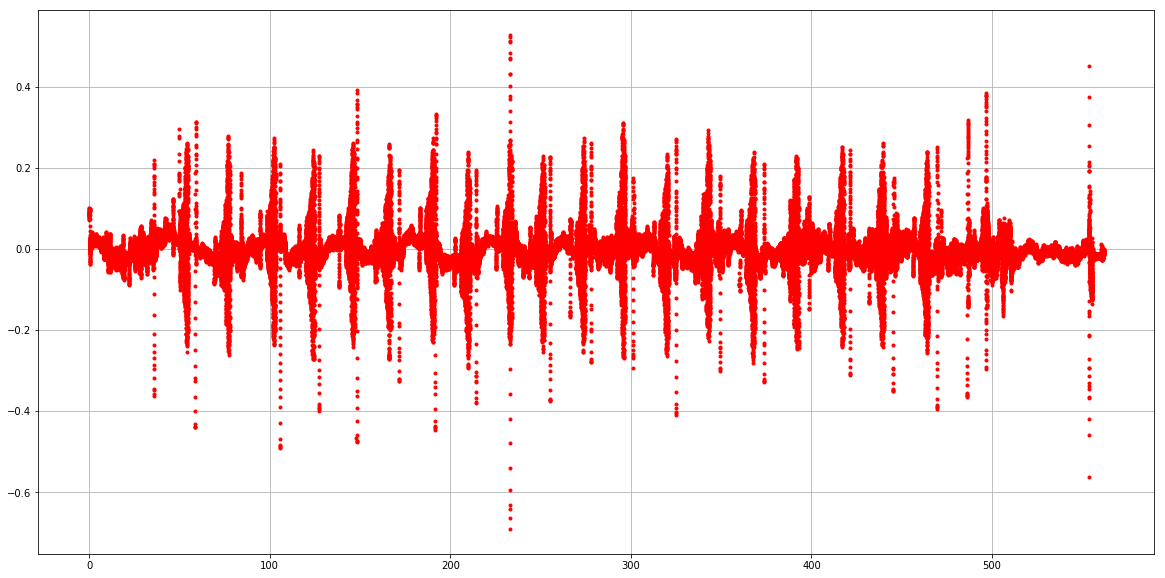

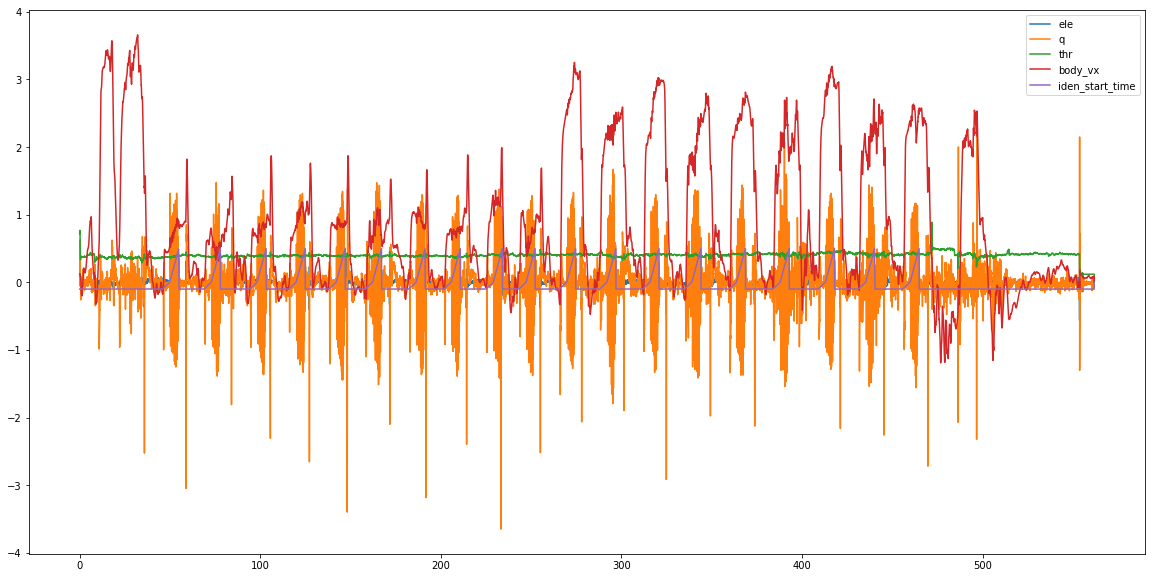

Stored 'px4_case' (PX4AircraftCase)
Stored 'px4_case_low' (PX4AircraftCase)


In [7]:
#process_file(fpath,status)
px4_case = PX4AircraftCase(fpath)
show_logs(px4_case)


fpath_low = "/Users/plane/Dropbox/FLYLOG/foam-tail-sitter/cruising/log_32_2018-4-10-15-53-08.ulg"
px4_case_low = PX4AircraftCase(fpath_low)
show_logs(px4_case_low)

%store px4_case
%store px4_case_low

Will start split data with ['iden_start_time']
Will start split data with ['iden_start_time']


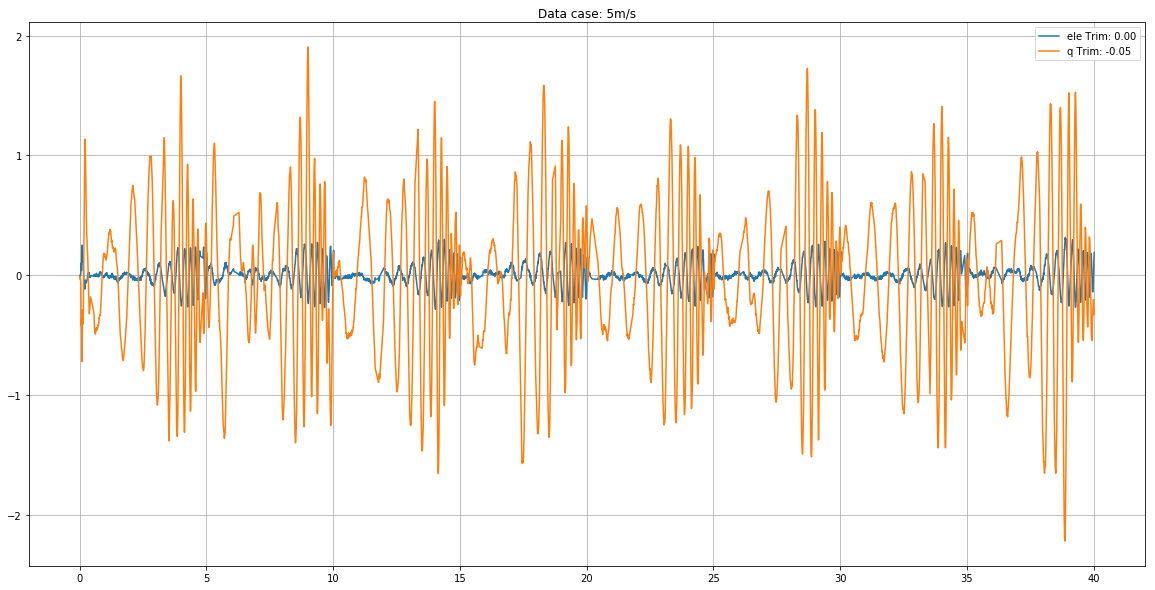

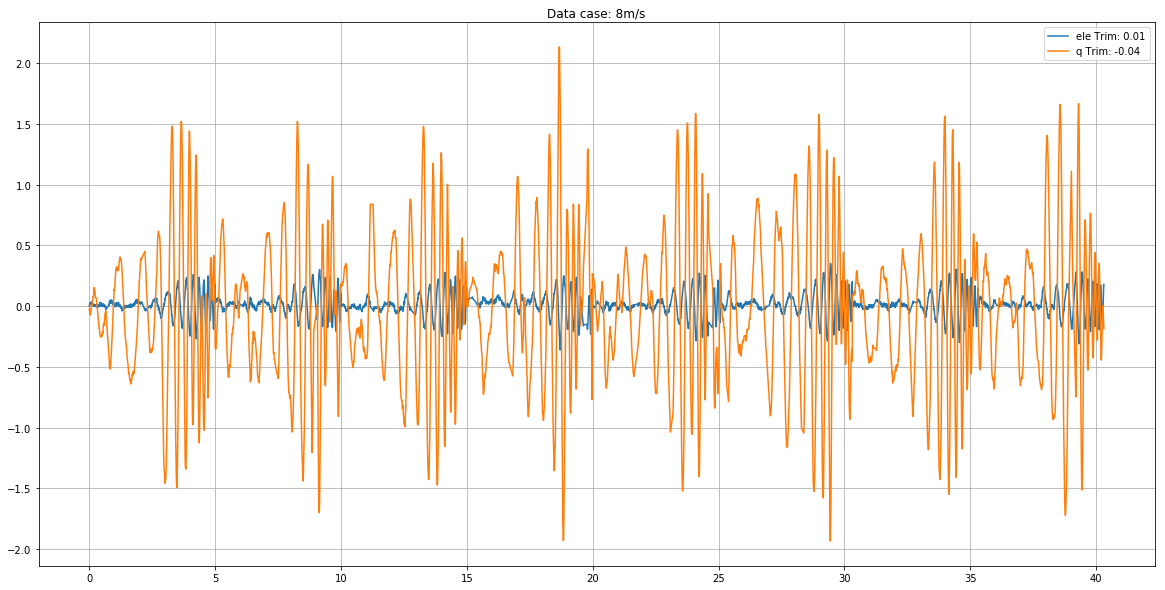

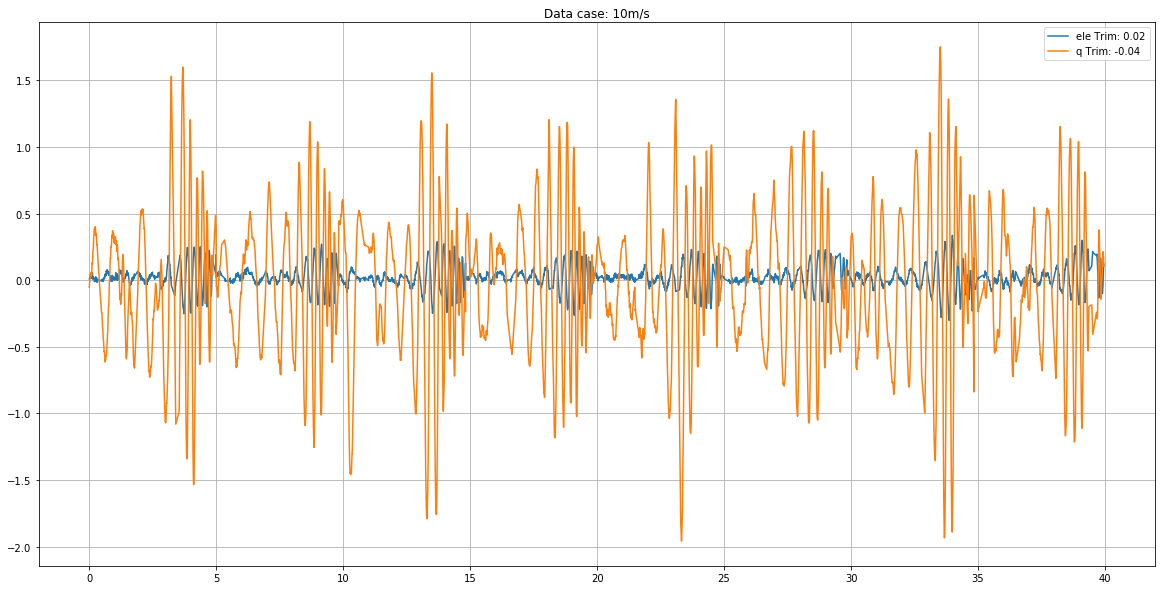

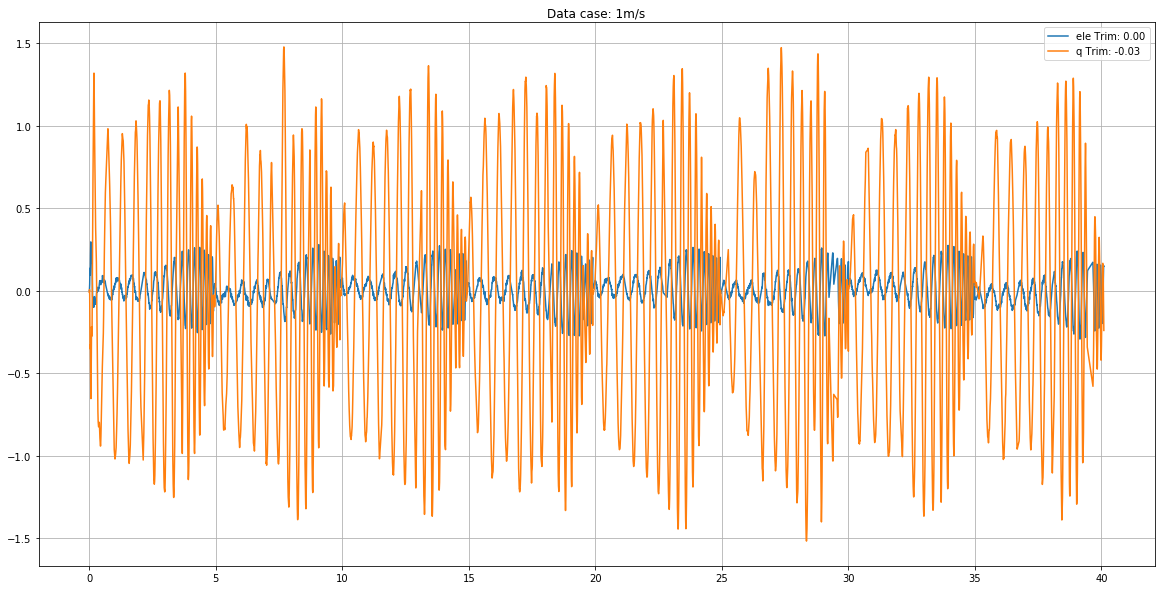

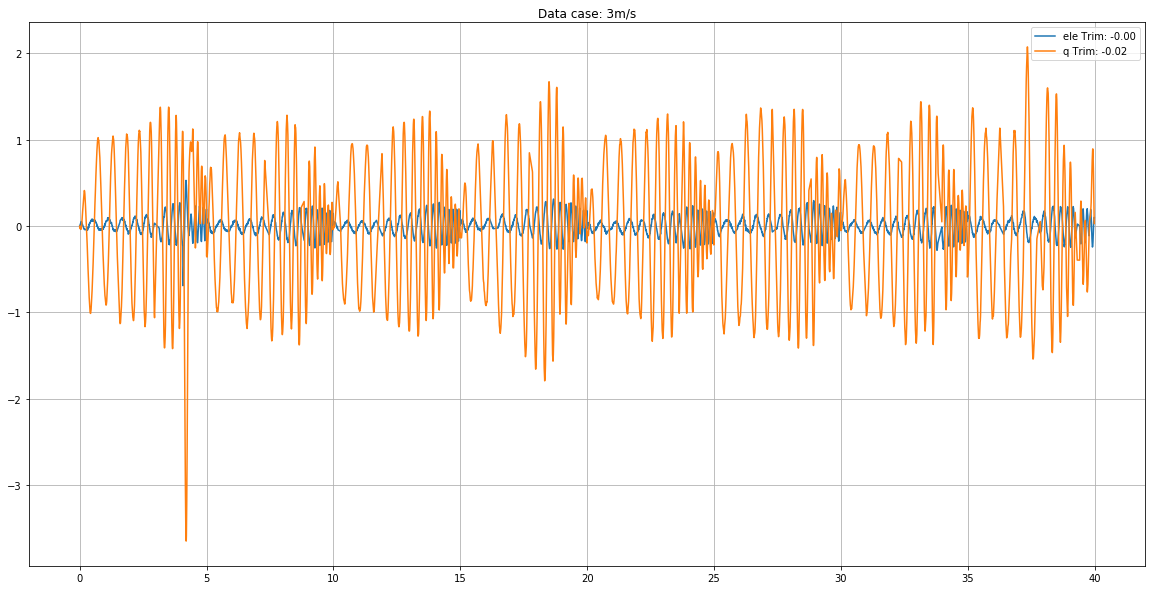

In [9]:
# %autoreload
# %store -r
plt.rc('figure', figsize=(20.0, 10.0))
data_splited = split_logs(px4_case)
data_splited = join_data(data_splited, status)
data_splited_low = split_and_join_data(px4_case_low, status_low)
needed_data = ['ele', 'q']
plot_status_data(px4_case, data_splited,needed_data)
plot_status_data(px4_case_low, data_splited_low,needed_data)

In [10]:
idens_ele = process_status_data(px4_case, data_splited, 10, 50)
idens_ele.update(process_status_data(px4_case_low, data_splited_low, 10, 50))

Sample rate is 199.99999999999997
Sample rate is 199.99999999999997
Setting-up composite win, sample rate 199.99999999999997 from omg 10 to 50
Composite using [5, 11, 17, 23, 30]


C:\Users\plane\Anaconda3\lib\site-packages\scipy\fftpack\basic.py:160: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  z[index] = x


Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 10 to 50
Composite using [5, 11, 18, 24, 31]
Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 10 to 50
Composite using [5, 11, 17, 23, 30]
Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 10 to 50
Composite using [5, 11, 17, 23, 30]
Sample rate is 200.0
Sample rate is 200.0
Setting-up composite win, sample rate 200.0 from omg 10 to 50
Composite using [5, 11, 17, 23, 30]


C:\Users\plane\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


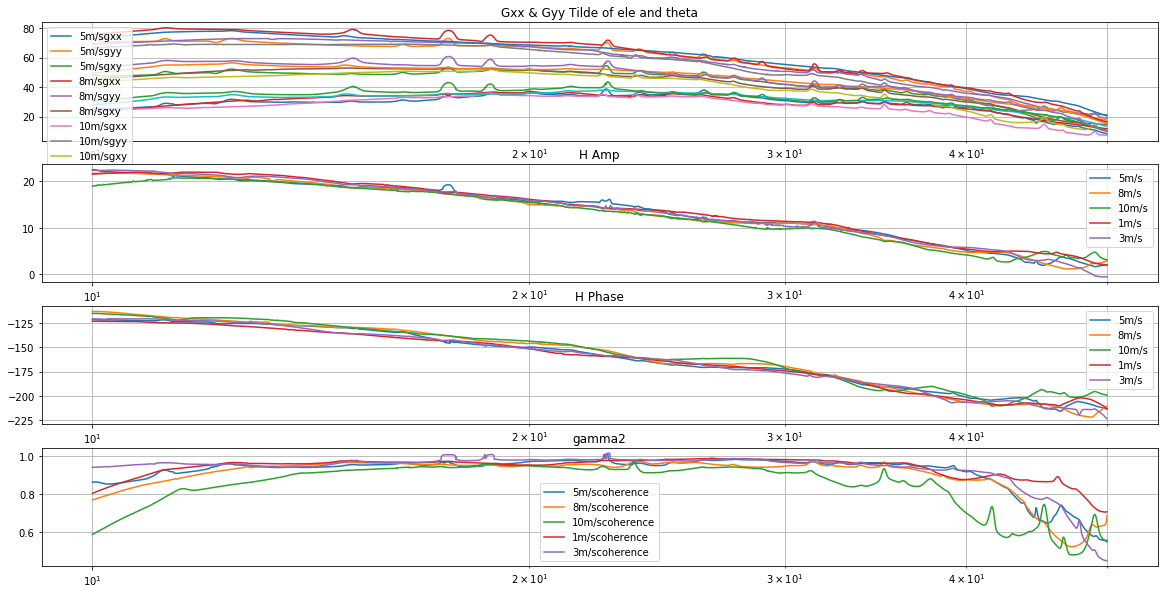

In [11]:
#%autoreload
plt.rc('figure', figsize=(20.0, 10.0))
plot_idens_for_status(idens_ele)

In [13]:
import sympy as sp


Uknown number 5 [d, a, tau, b, c]
Found new better 50.14225352861243All in pool finish


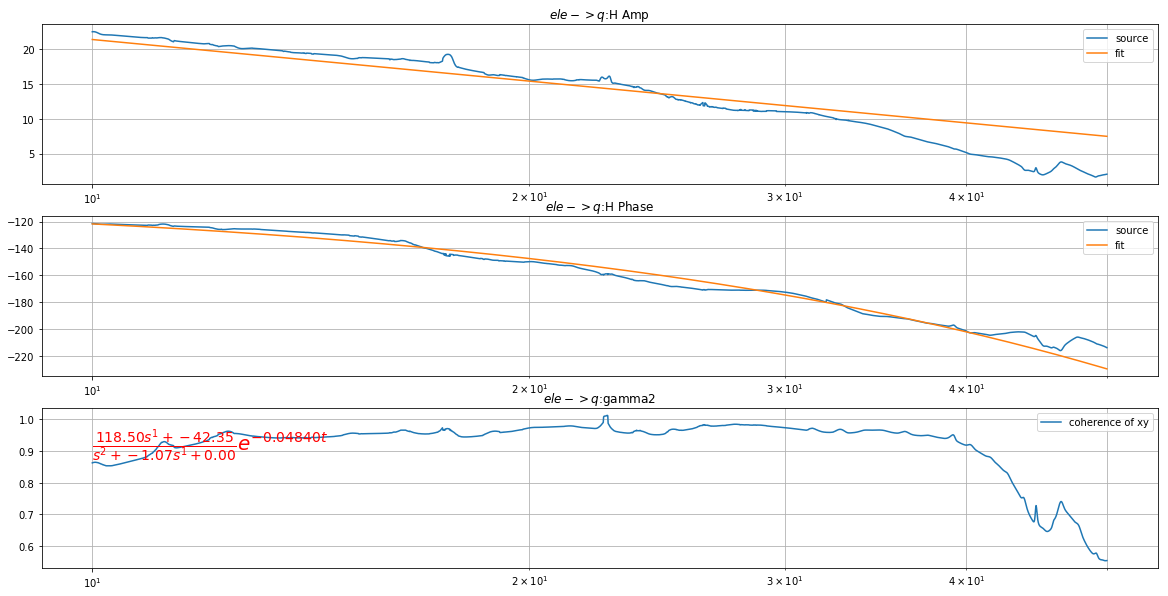

In [17]:
freq, H, gamma2, gxx, gxy, gyy = idens_ele["5m/s"].get_freq_iden(0)
a,b,c,d,e, tau,s = sp.symbols("a b c d e tau s")
num = a*s+b
den = (s*c + d)*s
tfpm = TransferFunctionParamModel(num,den,tau)
fitter = TransferFunctionFit(freq, H, gamma2, tfpm,nw=20,iter_times=20,reg = 0.1)
tf = fitter.estimate(5, 50,accept_J=15)
plot_fitter(fitter, "$ele -> q$")

In [59]:
for key in idens_ele:
    iden = idens_ele[key]
    iden.save_to_csv(0, "freqres_ele2q_"+key.split("/")[0]+"ps.csv")


Uknown number 6 [d, a, tau, b, c, e]
Found new better 22.142145683633164All in pool finish


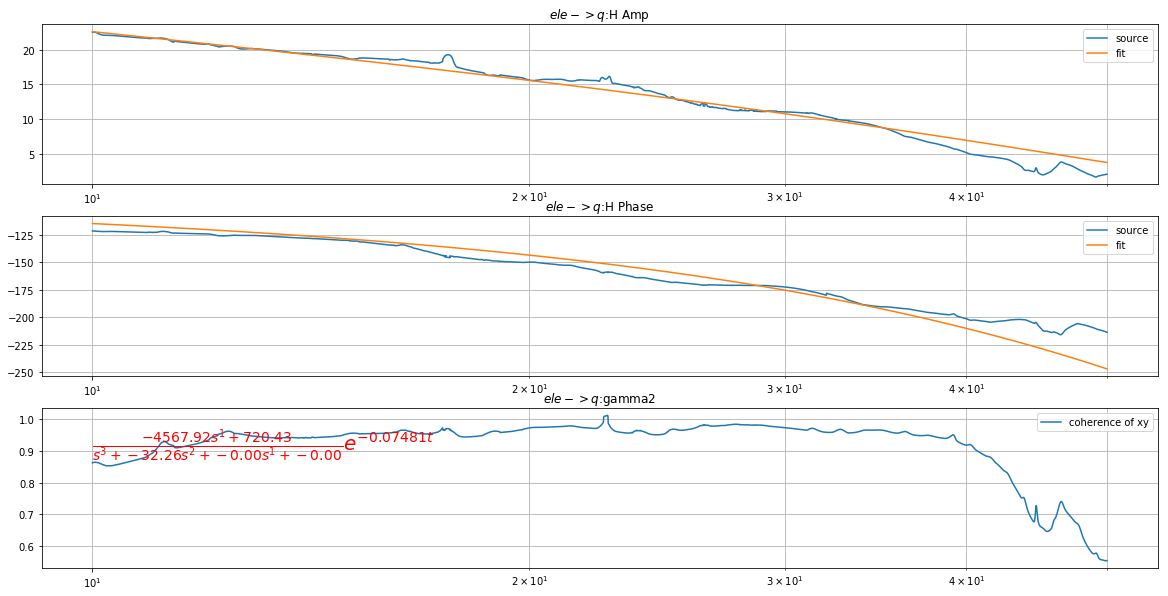

In [19]:
freq, H, gamma2, gxx, gxy, gyy = idens_ele["5m/s"].get_freq_iden(0)
a,b,c,d,e, f, tau,s = sp.symbols("a b c d e f tau s")
num = a*s+b
den = (s*s*c + d*s+e)*s
tfpm = TransferFunctionParamModel(num,den,tau)
fitter = TransferFunctionFit(freq, H, gamma2, tfpm,nw=20,iter_times=20,reg = 0.1)
tf = fitter.estimate(5, 50,accept_J=15)
plot_fitter(fitter, "$ele -> q$")